In [3]:
"""
TP4: Implémentation d'un système expert en Python avec visualisation graphique
Système de diagnostic respiratoire avec chaînage avant
Université Sultan My Slimane - ENSA Khouribga
"""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch
import networkx as nx

# ============================================================================
# PARTIE 1 : MODÉLISATION DES FAITS ET RÈGLES
# ============================================================================

R1 = {
    "nom": "R1",
    "conditions": ["fievre", "toux"],
    "conclusion": "grippe"
}

R2 = {
    "nom": "R2",
    "conditions": ["grippe", "douleurs_thoraciques"],
    "conclusion": "infection_respiratoire"
}

R3 = {
    "nom": "R3",
    "conditions": ["infection_respiratoire", "essoufflement"],
    "conclusion": "hospitalisation_conseillee"
}

BASE_REGLES = [R1, R2, R3]

In [4]:
# ============================================================================
# PARTIE 2 : CHAÎNAGE AVANT AVEC HISTORIQUE
# ============================================================================

def chainage_avant_avec_historique(faits_initiaux, regles):
    """
    Moteur d'inférence par chaînage avant avec historique des étapes.
    
    Retourne:
        tuple: (faits_finaux, historique)
    """
    faits = faits_initiaux.copy()
    historique = []
    nouveaux_faits = True
    iteration = 0
    
    print("\n" + "="*70)
    print("DÉBUT DU CHAÎNAGE AVANT")
    print("="*70)
    print(f"Faits initiaux: {faits}")
    print()
    
    while nouveaux_faits:
        nouveaux_faits = False
        iteration += 1
        print(f"--- Itération {iteration} ---")
        
        for regle in regles:
            conditions_satisfaites = all(
                condition in faits for condition in regle["conditions"]
            )
            
            if conditions_satisfaites and regle["conclusion"] not in faits:
                faits.append(regle["conclusion"])
                nouveaux_faits = True
                
                etape = {
                    "iteration": iteration,
                    "regle": regle["nom"],
                    "conditions": regle["conditions"].copy(),
                    "conclusion": regle["conclusion"],
                    "faits_avant": faits[:-1].copy(),
                    "faits_apres": faits.copy()
                }
                historique.append(etape)
                
                print(f"✓ Règle {regle['nom']} déclenchée:")
                print(f"  Conditions: {regle['conditions']}")
                print(f"  → Conclusion: {regle['conclusion']}")
        
        if not nouveaux_faits:
            print("Aucune nouvelle règle déclenchée.")
    
    print(f"\n{'='*70}")
    print(f"RÉSULTAT FINAL: {faits}")
    print(f"{'='*70}\n")
    
    return faits, historique

In [5]:
# ============================================================================
# PARTIE 3 : FONCTION peut_on_deduire
# ============================================================================

def peut_on_deduire(fait_cible, faits_initiaux, regles):
    """
    Vérifie si un fait cible peut être déduit.
    """
    print("\n" + "="*70)
    print(f"QUESTION: Peut-on déduire '{fait_cible}' ?")
    print("="*70)
    
    faits_finaux, _ = chainage_avant_avec_historique(faits_initiaux, regles)
    resultat = fait_cible in faits_finaux
    
    print("\n" + "-"*70)
    if resultat:
        print(f"✓ OUI, '{fait_cible}' peut être déduit(e)")
    else:
        print(f"✗ NON, '{fait_cible}' ne peut pas être déduit(e)")
    print("-"*70 + "\n")
    
    return resultat

In [6]:
# ============================================================================
# VISUALISATION GRAPHIQUE
# ============================================================================

def creer_graphe_inference(faits_initiaux, faits_deduits, regles_declenchees):
    """
    Crée un graphe de réseau montrant le processus d'inférence.
    """
    G = nx.DiGraph()
    
    # Positions prédéfinies pour un meilleur affichage
    pos = {}
    
    # Faits initiaux (colonne gauche)
    faits_symptomes = ["fievre", "toux", "douleurs_thoraciques", "essoufflement"]
    y_start = 3
    for i, fait in enumerate(faits_symptomes):
        pos[fait] = (0, y_start - i)
        G.add_node(fait, type='fait', statut='initial' if fait in faits_initiaux else 'absent')
    
    # Règles (milieu)
    pos["R1"] = (2, 2.5)
    pos["R2"] = (4, 1.5)
    pos["R3"] = (6, 0.5)
    
    for regle in BASE_REGLES:
        G.add_node(regle["nom"], type='regle', 
                  statut='declenchee' if regle["nom"] in regles_declenchees else 'non_declenchee')
    
    # Faits déduits (colonnes droite)
    pos["grippe"] = (3, 3)
    pos["infection_respiratoire"] = (5, 2)
    pos["hospitalisation_conseillee"] = (7, 1)
    
    for fait in ["grippe", "infection_respiratoire", "hospitalisation_conseillee"]:
        G.add_node(fait, type='fait', statut='deduit' if fait in faits_deduits else 'absent')
    
    # Ajouter les arêtes selon les règles
    for regle in BASE_REGLES:
        for condition in regle["conditions"]:
            if condition in G.nodes():
                G.add_edge(condition, regle["nom"])
        G.add_edge(regle["nom"], regle["conclusion"])
    
    return G, pos

def dessiner_schema(faits_initiaux, titre="Schéma du système expert"):
    """
    Dessine le schéma complet du système avec le résultat du chaînage avant.
    """
    # Exécuter le chaînage avant
    faits_finaux, historique = chainage_avant_avec_historique(faits_initiaux, BASE_REGLES)
    
    # Identifier les faits déduits et règles déclenchées
    faits_deduits = [f for f in faits_finaux if f not in faits_initiaux]
    regles_declenchees = [etape["regle"] for etape in historique]
    
    # Créer le graphe
    G, pos = creer_graphe_inference(faits_initiaux, faits_deduits, regles_declenchees)
    
    # Créer la figure
    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#f8f9fa')
    
    # Définir les couleurs
    couleurs_noeuds = []
    for node in G.nodes():
        if G.nodes[node]['type'] == 'fait':
            if G.nodes[node]['statut'] == 'initial':
                couleurs_noeuds.append('#2ecc71')  # Vert pour faits initiaux
            elif G.nodes[node]['statut'] == 'deduit':
                couleurs_noeuds.append('#e74c3c')  # Rouge pour faits déduits
            else:
                couleurs_noeuds.append('#95a5a6')  # Gris pour faits absents
        else:  # règle
            if G.nodes[node]['statut'] == 'declenchee':
                couleurs_noeuds.append('#9b59b6')  # Violet pour règles déclenchées
            else:
                couleurs_noeuds.append('#ecf0f1')  # Blanc cassé pour règles non déclenchées
    
    # Dessiner les arêtes
    for edge in G.edges():
        source, target = edge
        x1, y1 = pos[source]
        x2, y2 = pos[target]
        
        # Déterminer si l'arête est active
        if G.nodes[source].get('type') == 'regle':
            est_active = G.nodes[source]['statut'] == 'declenchee'
        else:
            # Pour les faits vers les règles
            regle = target
            est_active = G.nodes[regle]['statut'] == 'declenchee' and G.nodes[source]['statut'] != 'absent'
        
        arrow = FancyArrowPatch(
            (x1, y1), (x2, y2),
            arrowstyle='->', 
            color='#e74c3c' if est_active else '#34495e',
            linewidth=3 if est_active else 1.5,
            mutation_scale=20,
            alpha=0.8 if est_active else 0.4,
            zorder=1
        )
        ax.add_patch(arrow)
    
    # Dessiner les nœuds
    for node, (x, y) in pos.items():
        if G.nodes[node]['type'] == 'fait':
            # Rectangle pour les faits
            couleur_idx = list(G.nodes()).index(node)
            rect = FancyBboxPatch(
                (x - 0.4, y - 0.15), 0.8, 0.3,
                boxstyle="round,pad=0.05",
                facecolor=couleurs_noeuds[couleur_idx],
                edgecolor='black',
                linewidth=2,
                zorder=2
            )
            ax.add_patch(rect)
            
            # Texte du fait
            texte = node.replace('_', '\n')
            ax.text(x, y, texte, ha='center', va='center', 
                   fontsize=9, fontweight='bold', color='white', zorder=3)
        else:
            # Cercle pour les règles
            couleur_idx = list(G.nodes()).index(node)
            circle = Circle(
                (x, y), 0.25,
                facecolor=couleurs_noeuds[couleur_idx],
                edgecolor='black',
                linewidth=2,
                zorder=2
            )
            ax.add_patch(circle)
            
            # Texte de la règle
            ax.text(x, y, node, ha='center', va='center', 
                   fontsize=11, fontweight='bold', 
                   color='white' if G.nodes[node]['statut'] == 'declenchee' else 'black',
                   zorder=3)
    
    # Titre et légende
    ax.set_title(titre, fontsize=18, fontweight='bold', pad=20)
    
    # Créer la légende
    legende_elements = [
        mpatches.Patch(color='#2ecc71', label='Faits initiaux'),
        mpatches.Patch(color='#e74c3c', label='Faits déduits'),
        mpatches.Patch(color='#95a5a6', label='Faits absents'),
        mpatches.Patch(color='#9b59b6', label='Règles déclenchées'),
        mpatches.Patch(color='#ecf0f1', label='Règles non déclenchées')
    ]
    ax.legend(handles=legende_elements, loc='upper left', fontsize=10, 
             frameon=True, fancybox=True, shadow=True)
    
    # Ajouter les résultats textuels
    resultats_texte = f"Faits initiaux: {faits_initiaux}\nFaits déduits: {faits_deduits}"
    ax.text(0.5, -0.5, resultats_texte, ha='center', fontsize=11, 
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
           transform=ax.transData)
    
    ax.set_xlim(-1, 8)
    ax.set_ylim(-1, 4)
    ax.axis('off')
    
    plt.tight_layout()
    return fig, faits_finaux, historique


╔====================================================================╗
║  Système Expert - Diagnostic Respiratoire avec Visualisation  ║
║           ENSA Khouribga - Ingénierie des Connaissances       ║
╚====================================================================╝

██████████████████████████████████████████████████████████████████████
█               TESTS DU SYSTÈME EXPERT                              █
██████████████████████████████████████████████████████████████████████


CAS 1: faits_initiaux = ['fievre', 'toux']

DÉBUT DU CHAÎNAGE AVANT
Faits initiaux: ['fievre', 'toux']

--- Itération 1 ---
✓ Règle R1 déclenchée:
  Conditions: ['fievre', 'toux']
  → Conclusion: grippe
--- Itération 2 ---
Aucune nouvelle règle déclenchée.

RÉSULTAT FINAL: ['fievre', 'toux', 'grippe']

✓ Schéma sauvegardé: cas1_schema.png

CAS 2: faits_initiaux = ['fievre', 'toux', 'douleurs_thoraciques', 'essoufflement']

DÉBUT DU CHAÎNAGE AVANT
Faits initiaux: ['fievre', 'toux', 'douleurs_thoraciques',

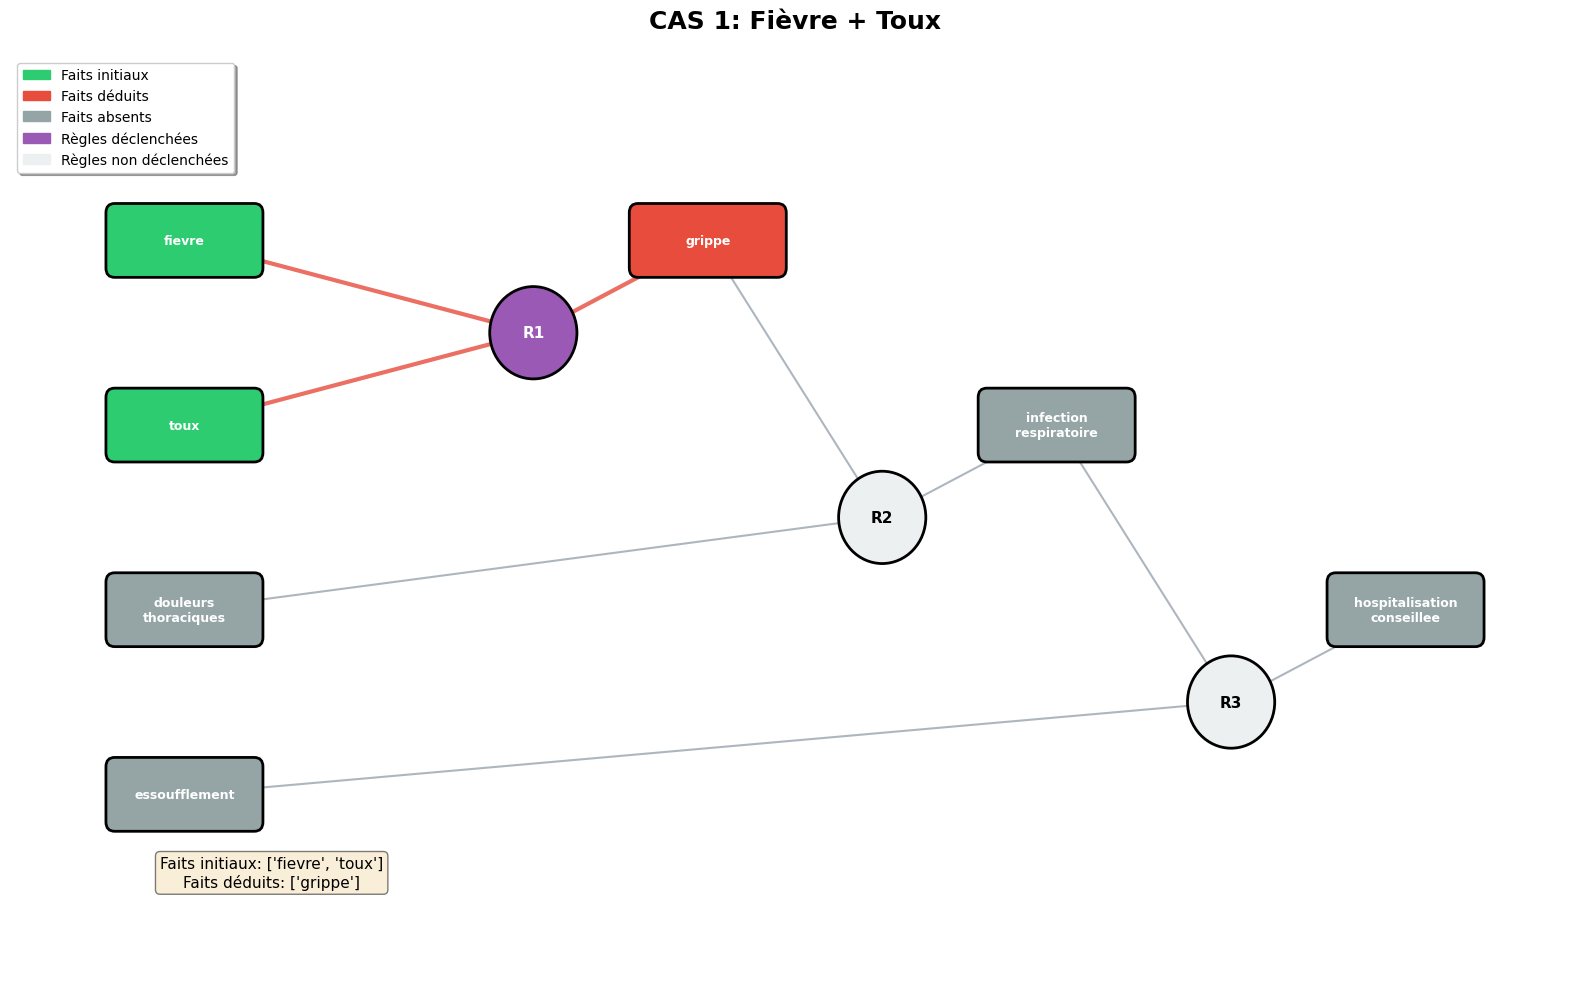

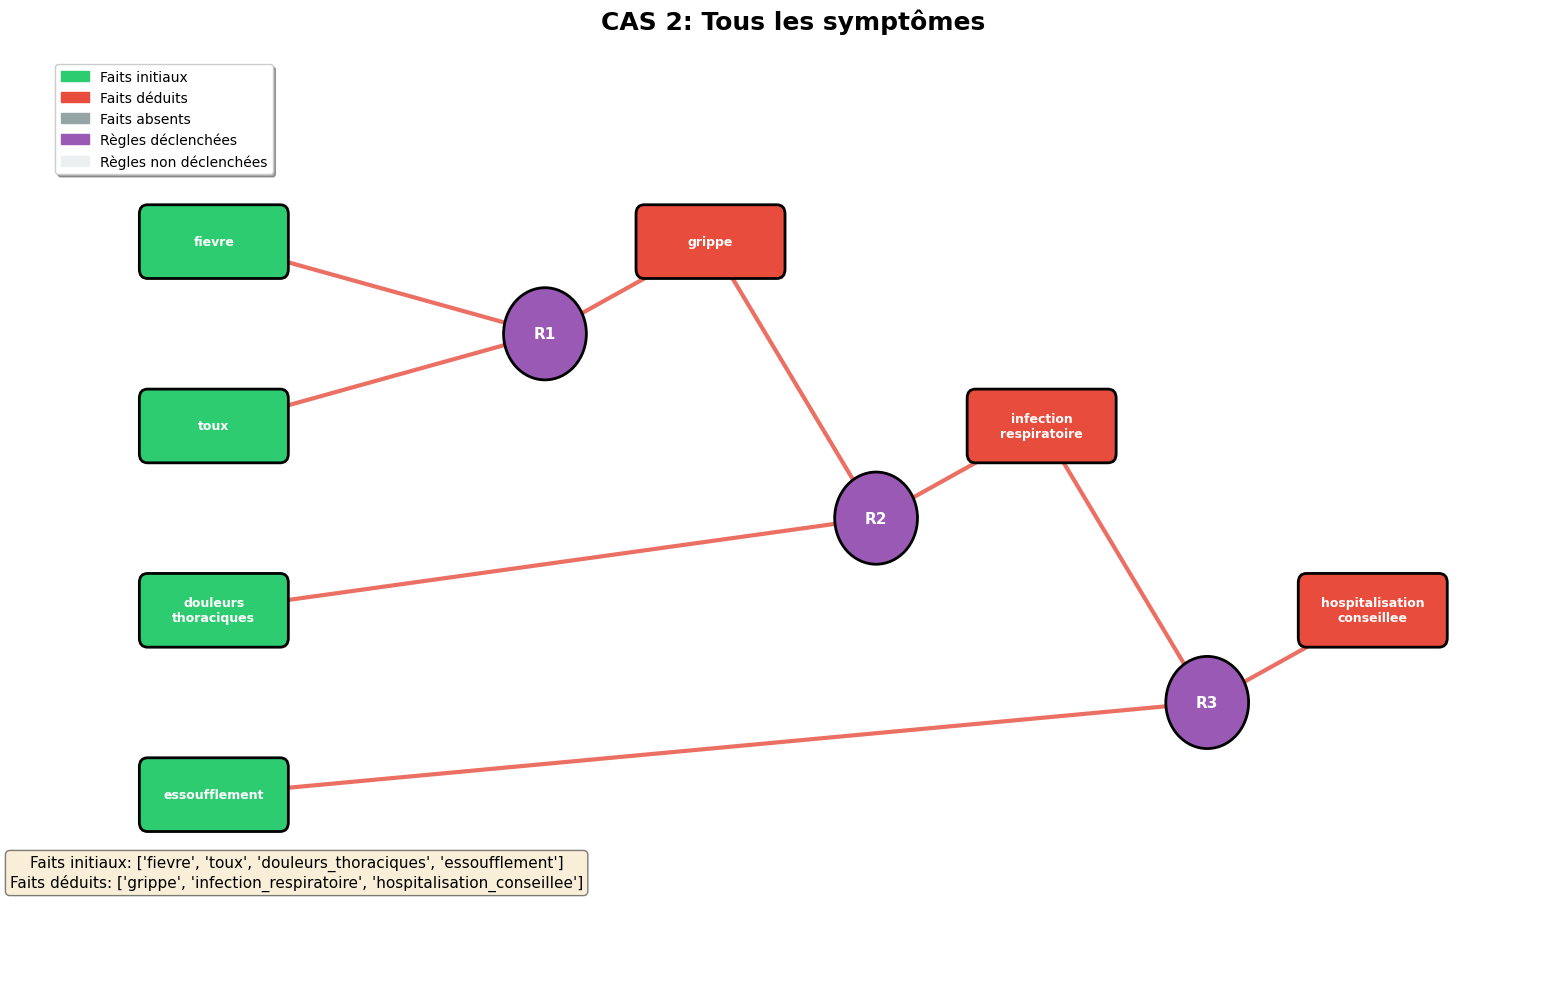

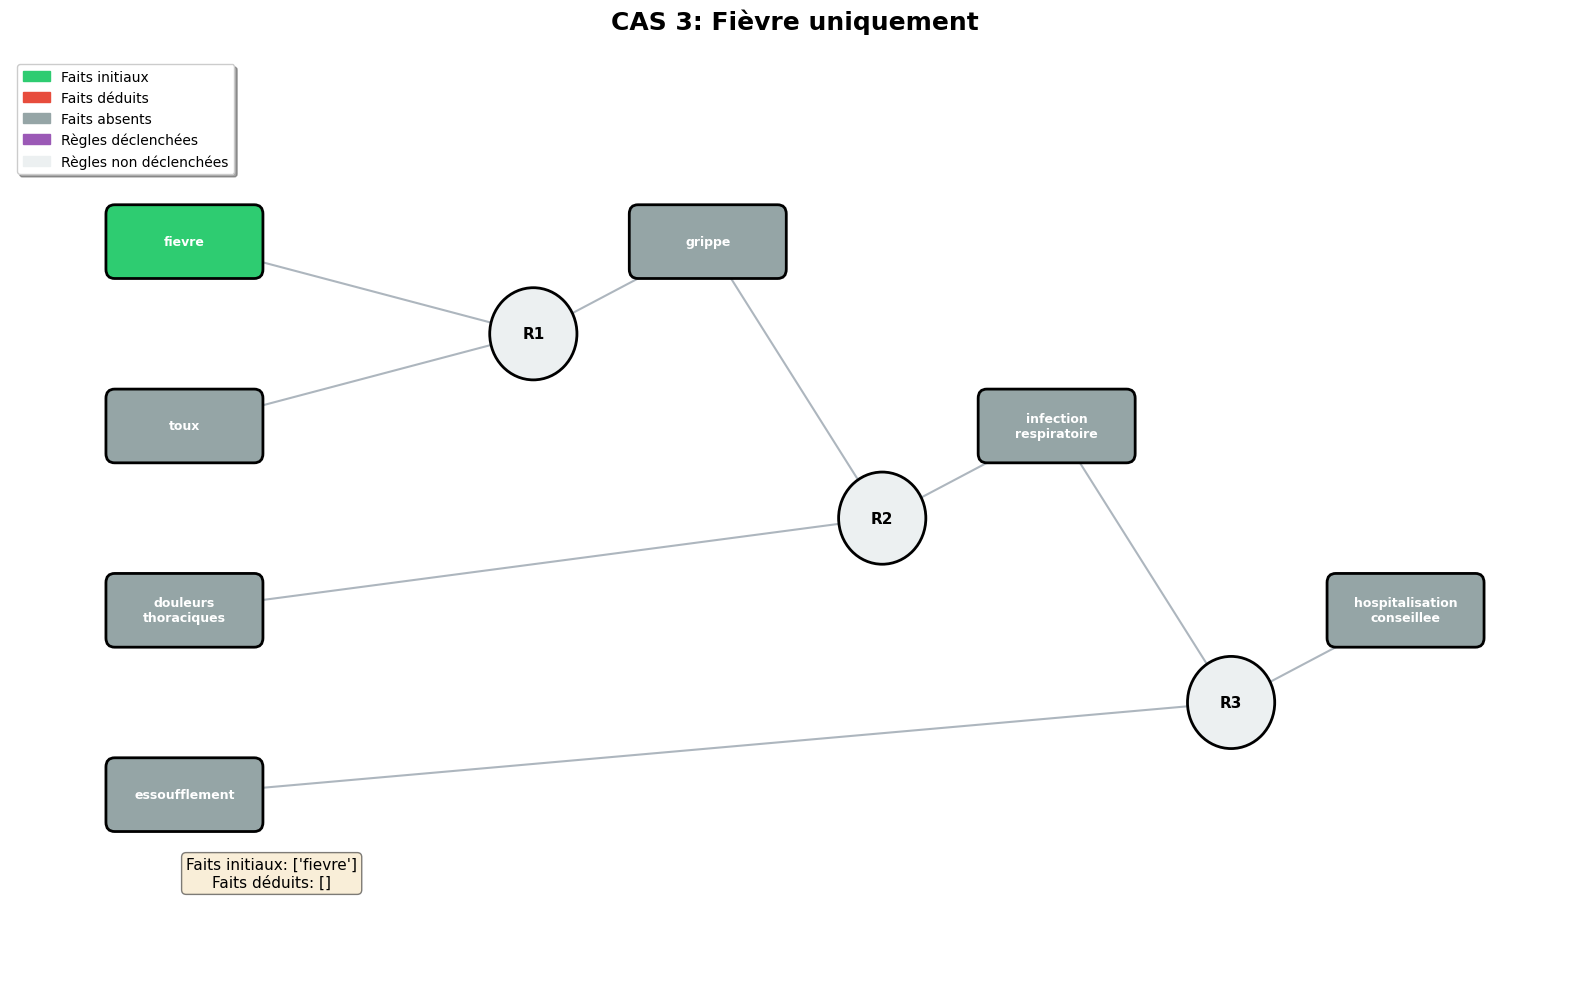


TESTS DE LA FONCTION peut_on_deduire()

QUESTION: Peut-on déduire 'infection_respiratoire' ?

DÉBUT DU CHAÎNAGE AVANT
Faits initiaux: ['fievre', 'toux', 'douleurs_thoraciques']

--- Itération 1 ---
✓ Règle R1 déclenchée:
  Conditions: ['fievre', 'toux']
  → Conclusion: grippe
✓ Règle R2 déclenchée:
  Conditions: ['grippe', 'douleurs_thoraciques']
  → Conclusion: infection_respiratoire
--- Itération 2 ---
Aucune nouvelle règle déclenchée.

RÉSULTAT FINAL: ['fievre', 'toux', 'douleurs_thoraciques', 'grippe', 'infection_respiratoire']


----------------------------------------------------------------------
✓ OUI, 'infection_respiratoire' peut être déduit(e)
----------------------------------------------------------------------


QUESTION: Peut-on déduire 'hospitalisation_conseillee' ?

DÉBUT DU CHAÎNAGE AVANT
Faits initiaux: ['fievre']

--- Itération 1 ---
Aucune nouvelle règle déclenchée.

RÉSULTAT FINAL: ['fievre']


---------------------------------------------------------------------

In [7]:
# ============================================================================
# TESTS DES CAS DEMANDÉS
# ============================================================================

def tester_tous_les_cas():
    """
    Teste tous les cas avec visualisation graphique.
    """
    print("\n" + "█"*70)
    print("█" + " "*15 + "TESTS DU SYSTÈME EXPERT" + " "*30 + "█")
    print("█"*70 + "\n")
    
    # CAS 1
    print("\n" + "="*70)
    print("CAS 1: faits_initiaux = ['fievre', 'toux']")
    print("="*70)
    fig1, _, _ = dessiner_schema(["fievre", "toux"], "CAS 1: Fièvre + Toux")
    plt.savefig('cas1_schema.png', dpi=300, bbox_inches='tight')
    print("✓ Schéma sauvegardé: cas1_schema.png")
    
    # CAS 2
    print("\n" + "="*70)
    print("CAS 2: faits_initiaux = ['fievre', 'toux', 'douleurs_thoraciques', 'essoufflement']")
    print("="*70)
    fig2, _, _ = dessiner_schema(
        ["fievre", "toux", "douleurs_thoraciques", "essoufflement"],
        "CAS 2: Tous les symptômes"
    )
    plt.savefig('cas2_schema.png', dpi=300, bbox_inches='tight')
    print("✓ Schéma sauvegardé: cas2_schema.png")
    
    # CAS 3
    print("\n" + "="*70)
    print("CAS 3: faits_initiaux = ['fievre']")
    print("="*70)
    fig3, _, _ = dessiner_schema(["fievre"], "CAS 3: Fièvre uniquement")
    plt.savefig('cas3_schema.png', dpi=300, bbox_inches='tight')
    print("✓ Schéma sauvegardé: cas3_schema.png")
    
    # Afficher tous les schémas
    plt.show()
    
    # Tests de peut_on_deduire
    print("\n" + "="*70)
    print("TESTS DE LA FONCTION peut_on_deduire()")
    print("="*70)
    
    peut_on_deduire("infection_respiratoire", 
                    ["fievre", "toux", "douleurs_thoraciques"], 
                    BASE_REGLES)
    
    peut_on_deduire("hospitalisation_conseillee", 
                    ["fievre"], 
                    BASE_REGLES)

# ============================================================================
# POINT D'ENTRÉE PRINCIPAL
# ============================================================================

if __name__ == "__main__":
    print("\n" + "╔" + "="*68 + "╗")
    print("║  Système Expert - Diagnostic Respiratoire avec Visualisation  ║")
    print("║           ENSA Khouribga - Ingénierie des Connaissances       ║")
    print("╚" + "="*68 + "╝")
    
    # Exécuter tous les tests avec visualisation
    tester_tous_les_cas()
    
    print("\n✓ Tous les schémas ont été générés et sauvegardés!")
    print("  - cas1_schema.png")
    print("  - cas2_schema.png")
    print("  - cas3_schema.png")